In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

from dataset.PatchExtractor import PatchExtractor
from flow_models.PatchNrModel import PatchNrModel
from operators.gaussian_blur import GaussianBlur
import torch

In [2]:
transformPIL = transforms.Compose([transforms.PILToTensor()])

In [3]:
file = "../data/set12/01.png"
image = transformPIL(Image.open(file))

In [4]:
k = 5
std = 2
#operator = GaussianBlur(k, std)
operator = lambda b: b
#padding = transforms.Pad([k//2,], padding_mode="edge")
#deg_blurred_image = blur(padding(deg_image).float())
blurred_image = operator(image.float())

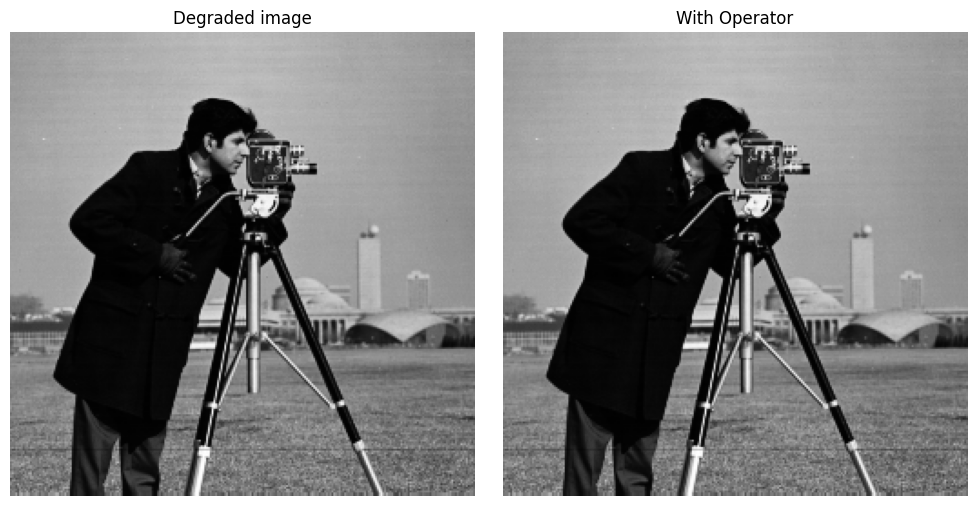

In [5]:
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('Degraded image')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(blurred_image.squeeze(), cmap='gray')
axes[1].set_title(f'With Operator')
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [6]:
mean = 0
std = 7
noise = np.random.normal(mean, std, image.shape)
# Create a figure with two subplots arranged horizontally
deg_image = torch.clip(blurred_image + noise, 0, 255)

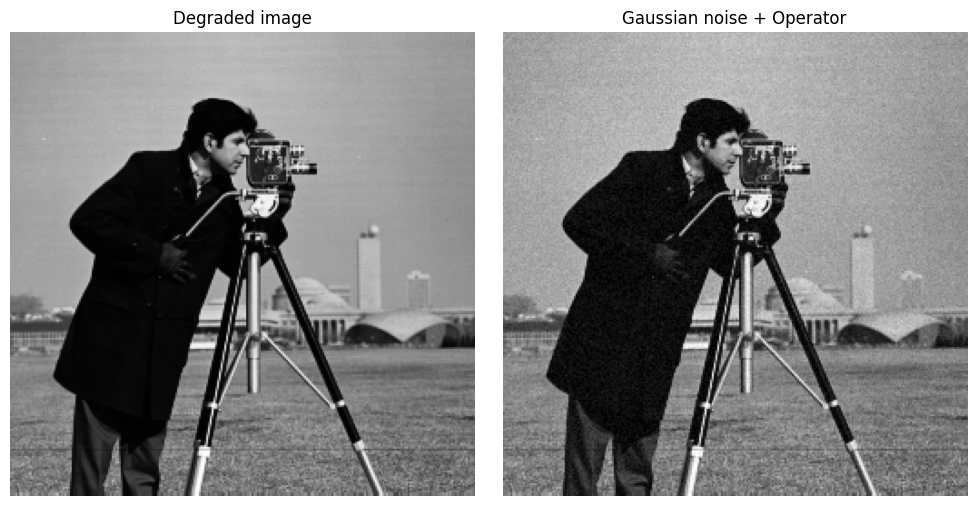

In [7]:
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title('Degraded image')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(deg_image.squeeze(), cmap='gray')
axes[1].set_title(f'Gaussian noise + Operator')
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [8]:
checkpoint = "../tb_logs/patch_nr_model/version_5/checkpoints/epoch=19-step=20000.ckpt"
hparams = "../tb_logs/patch_nr_model/version_5/hparams.yaml"
model = PatchNrModel.load_from_checkpoint(checkpoint_path=checkpoint, hparams_file=hparams)

In [9]:
num_patches = 10
patches, log = model.sample(num_patches)
patches = patches.detach().numpy()

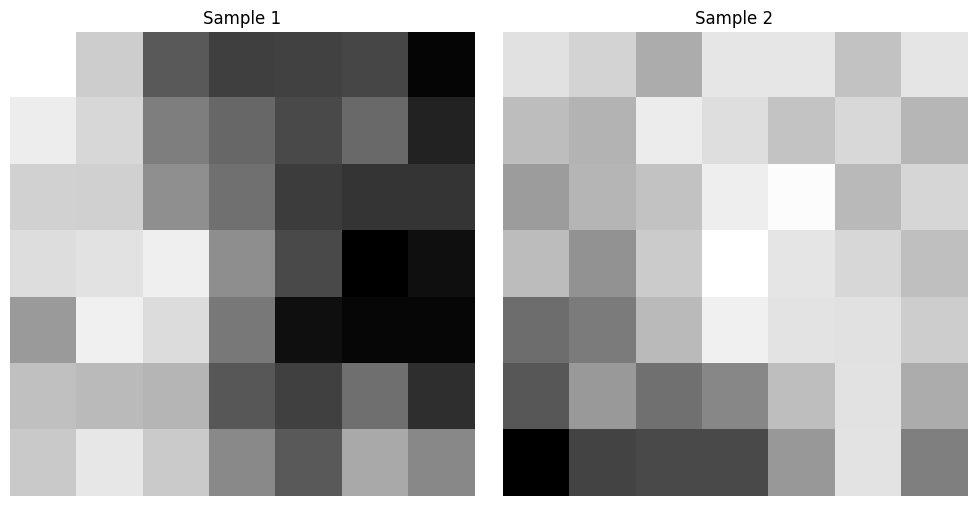

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(patches[0].reshape(7,7), cmap='gray')
axes[0].set_title('Sample 1')
axes[0].axis('off')
axes[1].imshow(patches[1].reshape(7,7), cmap='gray')
axes[1].set_title(f'Sample 2')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
class PatchNr_VM:

    def __init__(self, model, patch_size, random_patch_count, max_iter, device):
        self.model = model
        self.patch_size = patch_size
        self.random_patch_count = random_patch_count
        self.max_iter = max_iter
        self.device = device

    def reconstruct_img(self, name, deg_img, operator, lam=0.25, lr=1e-2):
        writer = SummaryWriter(comment=name)
        deg_img = deg_img.to(self.device)
        patch_size = (self.patch_size, self.patch_size)
        rec_img = deg_img.clone()
        optimizer = torch.optim.Adam([rec_img], lr=lr)
        for it in tqdm(range(self.max_iter)):
            optimizer.zero_grad()
            patch_extractor = PatchExtractor(rec_img, patch_size)
            random_rec_im_patches = torch.stack([patch_extractor.get_random_patch().flatten() for _ in range(self.random_patch_count)])
            pred_inv, log_det_inv = self.model.call_model(random_rec_im_patches, rev=False)
            reg = torch.mean(torch.sum(pred_inv ** 2, dim=1) / 2) - torch.mean(log_det_inv)
            lss_data_term = torch.sum((operator(rec_img) - deg_img) ** 2)
            loss = lss_data_term + lam * reg
            writer.add_scalar('loss', loss, it)
            writer.add_scalar('data-term', lss_data_term, it)
            writer.add_scalar('reg', reg, it)
            loss.backward()
            optimizer.step()
        writer.close()
        return rec_img

In [12]:
vm = PatchNr_VM(model, 7, 2000, max_iter=300, device='cpu')

In [13]:
result = vm.reconstruct_img('test1', deg_image.float(), lambda d: d, 2, 0.005)

  0%|          | 0/300 [00:00<?, ?it/s]

tensor(1.8023e+19, grad_fn=<SubBackward0>)


  1%|          | 2/300 [00:00<01:37,  3.05it/s]

tensor(1.8548e+19, grad_fn=<SubBackward0>)


  1%|          | 3/300 [00:00<01:25,  3.46it/s]

tensor(1.5757e+19, grad_fn=<SubBackward0>)


  1%|▏         | 4/300 [00:01<01:19,  3.70it/s]

tensor(3.4743e+19, grad_fn=<SubBackward0>)
tensor(2.8474e+19, grad_fn=<SubBackward0>)


  2%|▏         | 6/300 [00:01<01:31,  3.22it/s]

tensor(1.6633e+19, grad_fn=<SubBackward0>)


  2%|▏         | 7/300 [00:02<01:31,  3.21it/s]

tensor(4.4704e+19, grad_fn=<SubBackward0>)


  3%|▎         | 8/300 [00:02<01:32,  3.17it/s]

tensor(1.2837e+19, grad_fn=<SubBackward0>)


  3%|▎         | 9/300 [00:02<01:31,  3.19it/s]

tensor(2.1458e+19, grad_fn=<SubBackward0>)


  3%|▎         | 10/300 [00:03<01:27,  3.31it/s]

tensor(1.2497e+19, grad_fn=<SubBackward0>)


  4%|▎         | 11/300 [00:03<01:26,  3.33it/s]

tensor(1.6786e+19, grad_fn=<SubBackward0>)


  4%|▍         | 12/300 [00:03<01:21,  3.53it/s]

tensor(5.6314e+19, grad_fn=<SubBackward0>)


  4%|▍         | 13/300 [00:03<01:26,  3.31it/s]

tensor(1.6731e+19, grad_fn=<SubBackward0>)


  5%|▍         | 14/300 [00:04<01:28,  3.25it/s]

tensor(1.3822e+19, grad_fn=<SubBackward0>)


  5%|▌         | 15/300 [00:04<01:23,  3.43it/s]

tensor(1.3621e+19, grad_fn=<SubBackward0>)


  5%|▌         | 16/300 [00:04<01:18,  3.62it/s]

tensor(2.3123e+19, grad_fn=<SubBackward0>)


  6%|▌         | 17/300 [00:05<01:15,  3.76it/s]

tensor(3.1096e+19, grad_fn=<SubBackward0>)


  6%|▌         | 18/300 [00:05<01:12,  3.90it/s]

tensor(1.5933e+19, grad_fn=<SubBackward0>)


  6%|▋         | 19/300 [00:05<01:10,  3.98it/s]

tensor(2.0353e+19, grad_fn=<SubBackward0>)


  7%|▋         | 20/300 [00:05<01:09,  4.01it/s]

tensor(1.1553e+19, grad_fn=<SubBackward0>)


  7%|▋         | 21/300 [00:05<01:09,  4.02it/s]

tensor(1.7945e+19, grad_fn=<SubBackward0>)


  7%|▋         | 22/300 [00:06<01:10,  3.93it/s]

tensor(2.6320e+19, grad_fn=<SubBackward0>)


  8%|▊         | 23/300 [00:06<01:11,  3.86it/s]

tensor(1.9605e+19, grad_fn=<SubBackward0>)
tensor(1.9619e+19, grad_fn=<SubBackward0>)


  8%|▊         | 25/300 [00:07<01:21,  3.38it/s]

tensor(4.7408e+19, grad_fn=<SubBackward0>)


  9%|▊         | 26/300 [00:07<01:17,  3.52it/s]

tensor(3.3841e+19, grad_fn=<SubBackward0>)


  9%|▉         | 27/300 [00:07<01:18,  3.48it/s]

tensor(1.3369e+19, grad_fn=<SubBackward0>)


  9%|▉         | 28/300 [00:08<01:22,  3.30it/s]

tensor(2.1264e+19, grad_fn=<SubBackward0>)


  9%|▉         | 28/300 [00:08<01:19,  3.41it/s]


KeyboardInterrupt: 

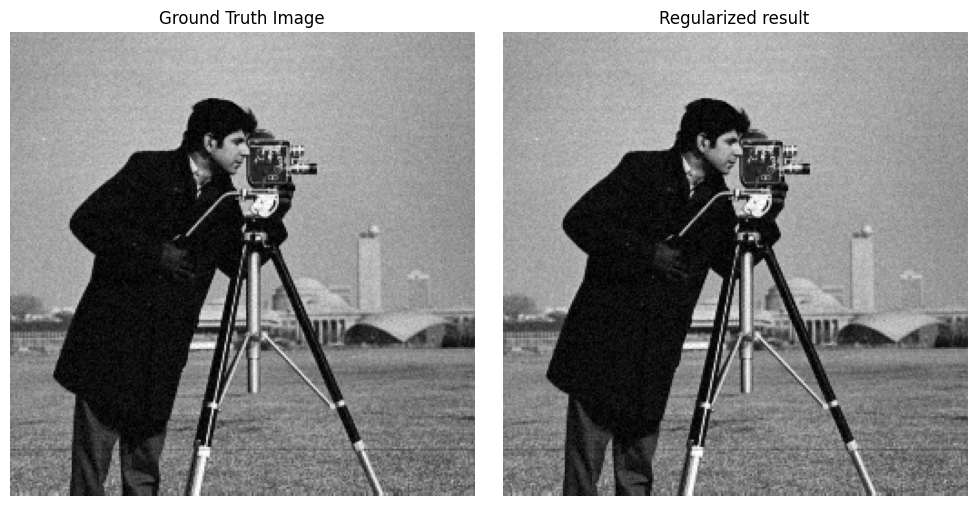

In [27]:
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(deg_image.squeeze(), cmap='gray')
axes[0].set_title('Ground Truth Image')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow(result.squeeze(), cmap='gray')
axes[1].set_title(f'Regularized result')
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

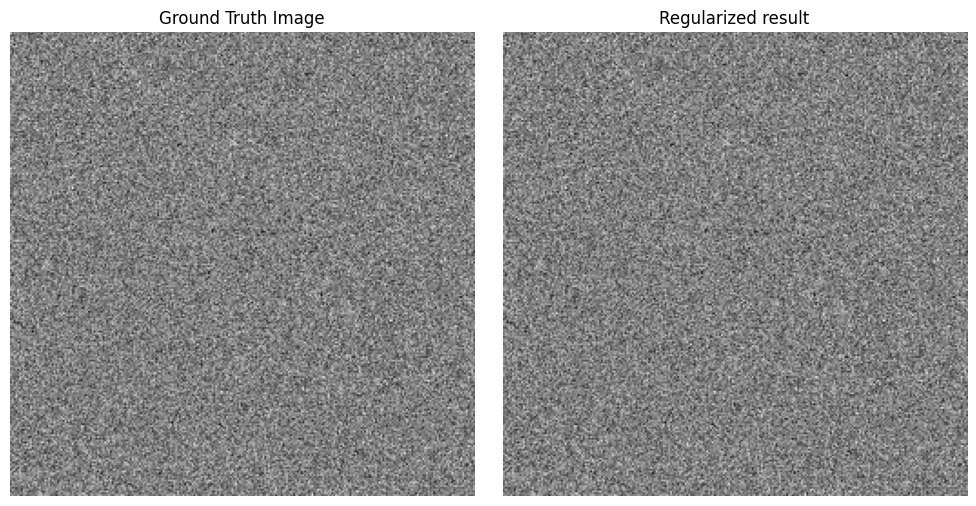

In [28]:
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow((image-deg_image).squeeze(), cmap='gray')
axes[0].set_title('Ground Truth Image')
axes[0].axis('off')

# Display the second image on the right subplot
axes[1].imshow((image-result).squeeze(), cmap='gray')
axes[1].set_title(f'Regularized result')
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [30]:
print(f'Diff noise{torch.sum((image-deg_image).flatten())}')
print(f'Diff regularized {torch.sum((image-result).flatten())}')

Diff noise-2302.709658644656
Diff regularized -2302.7080078125
